In [1]:
!pip install -q tensorflowjs
!nvidia-smi

Sat Jan 15 17:02:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    39W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#@title Runtime
use_tpu = False #@param


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
import json
np.random.seed(0)

In [3]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/human-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/human-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r['seqs']
    weights = r['weights']

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
weights = np.concatenate(
    (np.ones((pos_data.shape[0]), dtype=pos_data.dtype), 
     weights)
)
features = np.concatenate((pos_data, neg_data), axis=0)
pos_data_lengths = np.count_nonzero(pos_data, axis=1)
neg_data_lengths = np.count_nonzero(neg_data, axis=1)

In [4]:
print('Positive data', pos_data.shape[0])
print('Negative data', neg_data.shape[0])
print('Weights', weights)

Positive data 3600
Negative data 13585
Weights [1.         1.         1.         ... 0.02333456 0.02333456 0.02333456]


In [5]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(labels), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.3
               )


In [6]:
def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts /tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.LSTM(config.rnn_units)(e)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='human-rnn')
    return model

def build_infer_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)


    # RNN layer
    x = tf.keras.layers.LSTM(config.rnn_units)(e)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='human-rnn-infer')
    return model

In [7]:
if use_tpu:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.experimental.TPUStrategy(resolver)


In [13]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
np.random.shuffle(i)
np.random.shuffle(i)
shuffled_labels = labels[i]
shuffled_features = features[i]
shuffled_weights = weights[i]
# data = tf.data.Dataset.from_tensor_slices((shuffled_features, shuffled_labels, shuffled_weights))
data = tf.data.Dataset.from_tensor_slices((shuffled_features, shuffled_labels, shuffled_weights)).map(lambda x,y,z: ((x, counts_aa(x)), y, z))
# now split into val, test, train and batch
N = len(data)  
L = None#features[0].shape[-1]
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
if use_tpu:
  with strategy.scope():
    model = build_model(L)
else:
  tf.keras.backend.clear_session()
  model = build_model(L)

  decay_epochs = 50
  decay_steps = N  // config.batch_size * decay_epochs
  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
  opt = tf.optimizers.Adam(lr_decayed_fn)
  model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [15]:
model.summary()

Model: "human-rnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 32)     672         ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 64)           24832       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                          

In [16]:
result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)
        ],
    epochs=150)

lr = 0.001
Epoch 1/150
860/860 [==============================] - 13s 12ms/step - loss: 0.1548 - auc: 0.9010 - binary_accuracy: 0.8108 - val_loss: 0.1236 - val_auc: 0.9293 - val_binary_accuracy: 0.8143
lr = 0.000999368
Epoch 2/150
860/860 [==============================] - 9s 10ms/step - loss: 0.1292 - auc: 0.9206 - binary_accuracy: 0.8200 - val_loss: 0.1233 - val_auc: 0.9305 - val_binary_accuracy: 0.7875
lr = 0.0009974734
Epoch 3/150
860/860 [==============================] - 9s 10ms/step - loss: 0.1256 - auc: 0.9232 - binary_accuracy: 0.8206 - val_loss: 0.1204 - val_auc: 0.9311 - val_binary_accuracy: 0.8091
lr = 0.0009943211
Epoch 4/150
860/860 [==============================] - 9s 10ms/step - loss: 0.1246 - auc: 0.9241 - binary_accuracy: 0.8201 - val_loss: 0.1229 - val_auc: 0.9272 - val_binary_accuracy: 0.7986
lr = 0.000989919
Epoch 5/150
860/860 [==============================] - 9s 10ms/step - loss: 0.1229 - auc: 0.9264 - binary_accuracy: 0.8196 - val_loss: 0.1230 - val_auc: 0.929

108/108 [==============================] - 1s 4ms/step - loss: 0.1181 - auc: 0.9332 - binary_accuracy: 0.8201


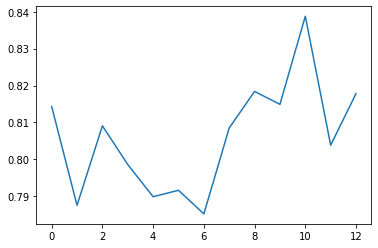

In [17]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate(test_data)
plt.show()

In [18]:
inference_model = build_infer_model(L)

inference_model.set_weights(model.get_weights())

In [19]:
inference_model([np.array([1,1,1,1]).reshape(1,-1), np.array(np.ones(20)/20).reshape(1,-1)])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4975852]], dtype=float32)>

In [20]:
# serialize model to JSON
inference_model_json = inference_model.to_json()
with open("../models/human-rnn/keras_model/model.json", "w") as json_file:
    json_file.write(inference_model_json)
# serialize weights to HDF5
inference_model.save_weights("../models/human-rnn/keras_model/model_weights.h5")

In [21]:
tfjs.converters.save_keras_model(inference_model, "../models/human-rnn/")

# Model Card

In [23]:
model_card = {
    'title': 'Nonfouling Prediction',
    'details': 'Recurrent (LSTM) neural network for predicting resistance to non-specific interactions (nonfouling). Developed by Andrew White using data from Barrett 2018. '
    'Negative examples are insoluble peptides, hemolytic peptides, and scrambled positives. Sample weights were used to remove negative example dataset sizes',
    'use': 'Short peptides between 2 and 20 residues',
    'factors': 'The dataset was gathered based on mechanism proposed in White 2012.',
    'metrics': f'Test accuracy {test_result[2]:.2f}. Test AUC {test_result[1]:.2f}',
    'evaluation': 'Withheld positive and negative examples',
    'training': f'{len(pos_data) + len(neg_data)} positive (length range: {np.min(pos_data_lengths)}-{np.max(pos_data_lengths)}) and negative (length range: {np.min(neg_data_lengths)}-{np.max(neg_data_lengths)}) sequences',
    'caveats': 'This data is mostly short sequences. The mechanism is indirect. '
    'The negative examples have insoluble peptides overrepresented so that the accuracy may be inflated if only comparing soluble peptides.',
    'ethics': 'None noted'
}
with open('../models/human-rnn/card.json', 'w') as f:
  json.dump(model_card, f)
print(json.dumps(model_card, indent=True))

{
 "title": "Nonfouling Prediction",
 "details": "Recurrent (LSTM) neural network for predicting resistance to non-specific interactions (nonfouling). Developed by Andrew White using data from Barrett 2018. Negative examples are insoluble peptides, hemolytic peptides, and scrambled positives. Sample weights were used to remove negative example dataset sizes",
 "use": "Short peptides between 2 and 20 residues",
 "factors": "The dataset was gathered based on mechanism proposed in White 2012.",
 "metrics": "Test accuracy 0.82. Test AUC 0.93",
 "evaluation": "Withheld positive and negative examples",
 "training": "17185 positive (length range: 5-11) and negative (length range: 5-198) sequences",
 "caveats": "This data is mostly short sequences. The mechanism is indirect. The negative examples have insoluble peptides overrepresented so that the accuracy may be inflated if only comparing soluble peptides.",
 "ethics": "None noted"
}
